<a href="https://colab.research.google.com/github/Jagoda222/DL_assignment2/blob/Kristina/DL_MEG_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h5py
!pip install mne
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import mne

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading & Analysis

<class 'numpy.ndarray'>
(248, 35624)


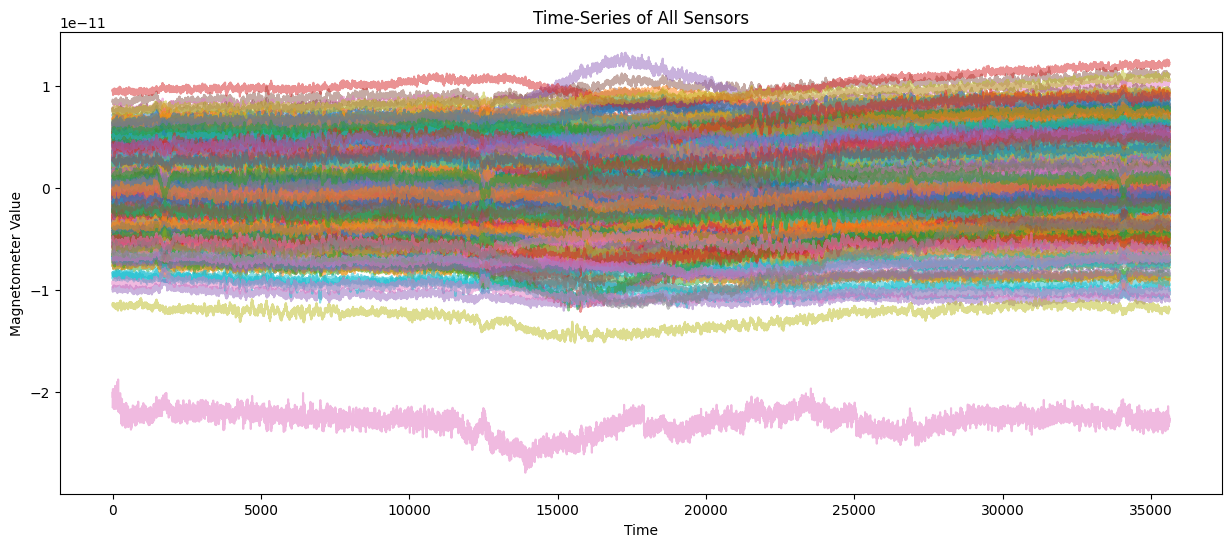

In [3]:
def get_dataset_name(filename_with_dir):
    filename_without_dir = filename_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = '_'.join(temp)
    return dataset_name

filename_path = '/content/drive/MyDrive/Final Project data/Intra/train/rest_105923_1.h5'


with h5py.File(filename_path, 'r') as f:
    dataset_name = get_dataset_name(filename_path)
    matrix = f.get(dataset_name)[()]
    print(type(matrix))
    print(matrix.shape)


plt.figure(figsize=(15, 6))

for i in range(matrix.shape[0]):  # 248 sensors (rows)
    plt.plot(matrix[i], alpha=0.5)  # `alpha` adds transparency to avoid overlap

plt.xlabel('Time')
plt.ylabel('Magnetometer Value')
plt.title('Time-Series of All Sensors')
plt.show()



In [4]:
data_dir = '/content/drive/MyDrive/Final Project data/Intra/train'
# File listing
files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Preallocate lists
raws = []     # MNE Raw objects
labels = []   # Task labels

# Constants
sfreq = 2034  # Hz >> for downsampling later
n_channels = 248 # channel = sensor
ch_names = [f'MEG {i:03d}' for i in range(n_channels)]
ch_types = ['mag'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types, verbose=False)

# extract full task label (e.g., task_motor, rest)
def get_task_label(filename):
    parts = filename.split('_')
    if parts[0] == 'rest':
        return 'rest'
    elif parts[0] == 'task':
        label_parts = []
        for part in parts[1:]:
            if part.isdigit():
                break
            label_parts.append(part)
        return '_'.join(label_parts)
    else:
        return 'unknown'


# extract dataset name inside HDF5 file
def get_dataset_name(filename):
    return '_'.join(filename.split('_')[:-1])

# Loop through files
for fname in sorted(files):
    fpath = os.path.join(data_dir, fname)
    task_label = get_task_label(fname)

    with h5py.File(fpath, 'r') as f:
        dataset_name = get_dataset_name(fname)
        data = f[dataset_name][()]  # shape: (248, 35624)

    # Create MNE Raw object
    raw = mne.io.RawArray(data, info, verbose = 0)

    # Store
    raws.append(raw)
    labels.append(task_label)

In [5]:
print(f"Number of recordings: {len(raws)}")
print(f"Unique tasks: {set(labels)}")
print(f"Info: {raw.info}")
data, times = raw[:, :]  # shape: (n_channels, n_times)
print("Min value:", data.min())
print("Max value:", data.max())

Number of recordings: 32
Unique tasks: {'working_memory', 'story_math', 'rest', 'motor'}
Info: <Info | 7 non-empty values
 bads: []
 ch_names: MEG 000, MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1017.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 2034.0 Hz
>
Min value: -1.6864036556096806e-10
Max value: 1.735352139764501e-11


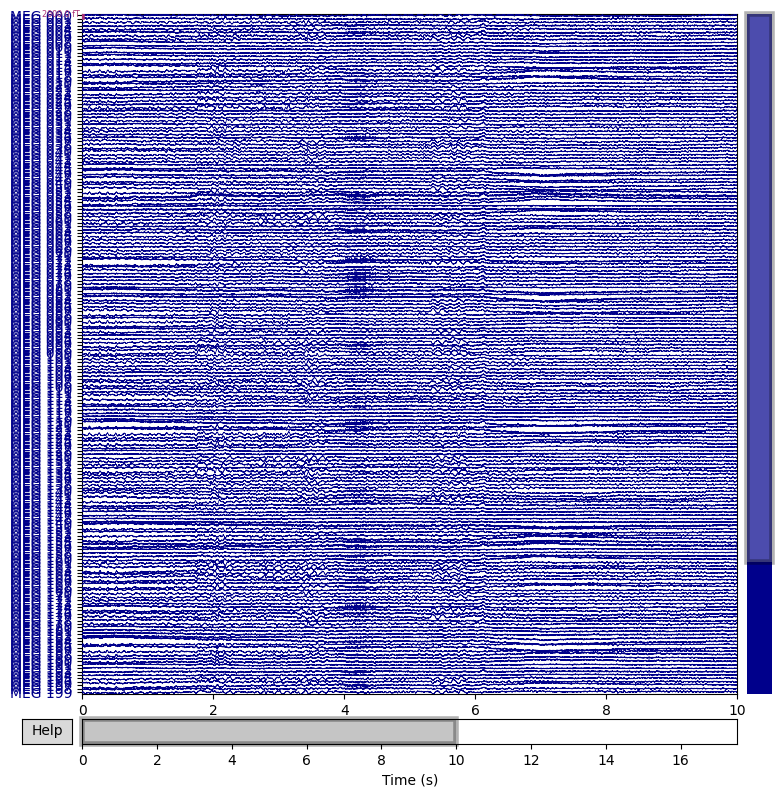

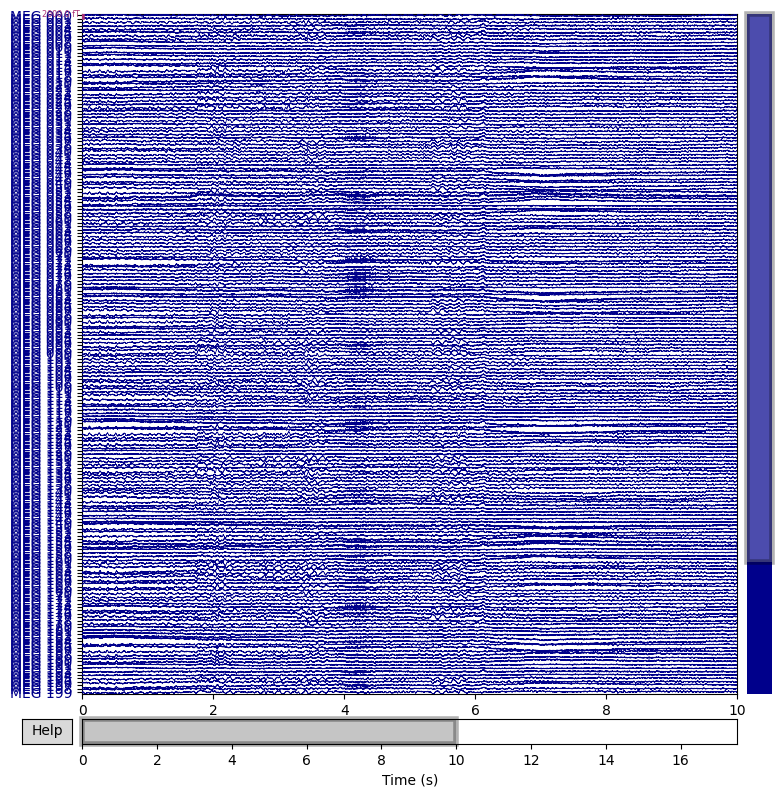

In [16]:
raws[16].plot(n_channels = 200)

In [6]:
def bandpass_filter(data, low_freq, high_freq):
  data_copy = data.copy()
  for raw in data_copy:
    raw.filter(l_freq=low_freq, h_freq=high_freq, filter_length='auto', verbose = False)
  return data_copy

def downsampling(data, new_freq):
  data_copy = data.copy()
  for raw in data_copy:
    raw.resample(new_freq, verbose=False)
  return data_copy



def epoching(data, labels, epoch_duration, overlap = 0.3):
  event_id = {
    'motor': 1,
    'working_memory': 2,
    'story_math': 3,
    'rest': 4}

  # This list will store the final Epochs objects (each one corresponding to a trial or sub-trial).
  all_epochs = []
  epoched_labels = []

  # Create epochs from resampled raw files and labels
  for raw, label in zip(data, labels):  # Iterates over resampled raw MEG recordings and their task labels.

      # Compute epoch start points in samples
      sfreq = raw.info['sfreq']  # sampling frequency
      n_samples = raw.n_times
      samples_per_epoch = int(epoch_duration * sfreq)

      # Create multiple events spaced by epoch_duration
      step_size = int(samples_per_epoch * (1 - overlap))
      start_samples = np.arange(0, n_samples - samples_per_epoch + 1, step_size)
      events = np.array([[start, 0, event_id[label]] for start in start_samples])

      this_event_id = {label: event_id[label]}  # Select the specific event ID for this label (e.g., {‘motor’: 1}).

      # Creates epochs of fixed length within the raw file.
      epoch = mne.Epochs(
          raw,
          events=events,
          event_id=this_event_id,
          tmin=0,
          tmax=epoch_duration,  # duration of each chunk
          baseline=None,
          preload=True,
          verbose = False
      )
      all_epochs.append(epoch)
      epoched_labels.extend([label] * len(epoch))
      combined_epochs = mne.concatenate_epochs(all_epochs)
      epoched_data = combined_epochs.get_data()

  return epoched_data, epoched_labels


# channel-wise normalization
def z_norm(data):
    normalized_data = np.empty_like(data, dtype=np.float32)
    num_channels = data.shape[1]

    for ch in range(num_channels):
        channel_data = data[:, ch, :].ravel()  # Flatten across trials and timesteps
        mean = np.mean(channel_data)
        std = np.std(channel_data)

        # Avoid division by zero
        if std == 0:
            normalized_data[:, ch, :] = 0
        else:
            normalized_data[:, ch, :] = (data[:, ch, :] - mean) / std

    return normalized_data


# time-wise normalization - normalize across all channels at each time point, within each epoch
def time_wise_norm(data):
  data_norm = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-6)
  return data_norm

In [7]:
downsampled_data = downsampling(raws, 500)
filtered_data = bandpass_filter(downsampled_data, 1, 40)
epoched_data, epoched_labels = epoching(filtered_data, labels, 1)

Not setting metadata
24 matching events found
No baseline correction applied
Not setting metadata
48 matching events found
No baseline correction applied
Not setting metadata
72 matching events found
No baseline correction applied
Not setting metadata
96 matching events found
No baseline correction applied
Not setting metadata
120 matching events found
No baseline correction applied
Not setting metadata
144 matching events found
No baseline correction applied
Not setting metadata
168 matching events found
No baseline correction applied
Not setting metadata
192 matching events found
No baseline correction applied
Not setting metadata
216 matching events found
No baseline correction applied
Not setting metadata
240 matching events found
No baseline correction applied
Not setting metadata
264 matching events found
No baseline correction applied
Not setting metadata
288 matching events found
No baseline correction applied
Not setting metadata
312 matching events found
No baseline correctio

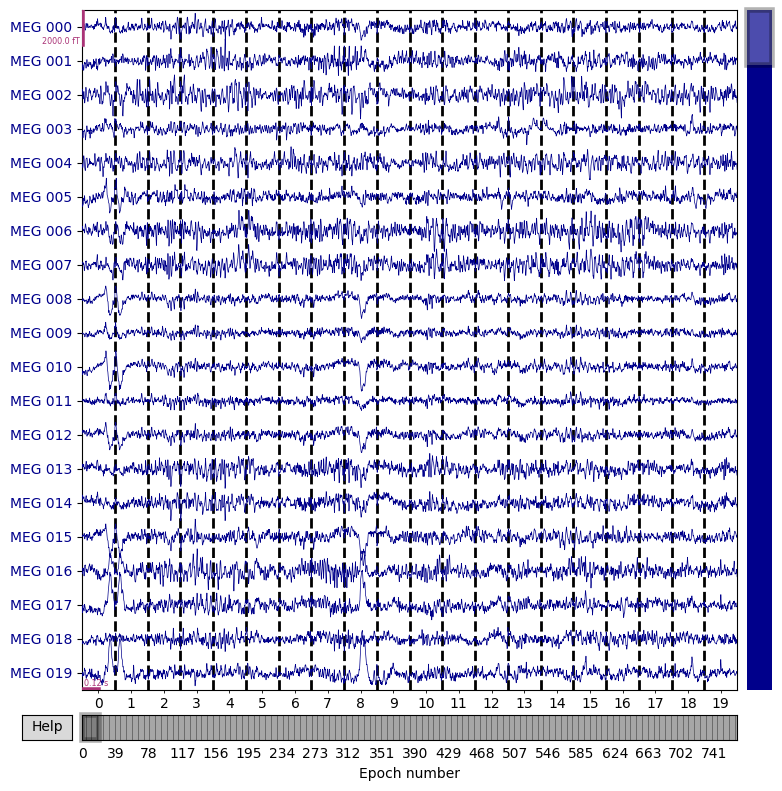

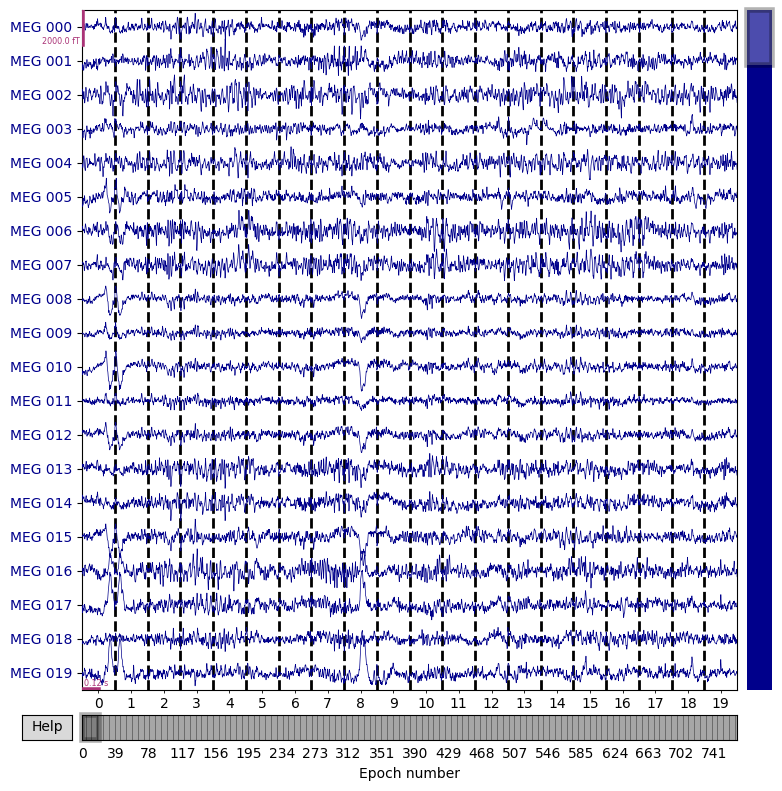

In [19]:
mne.EpochsArray(epoched_data, info, verbose = False).plot()

In [8]:
norm_data = z_norm(epoched_data)

# Classification Models

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(epoched_labels)
print(len(y))

X = norm_data.transpose(0,2,1)
print(X.shape)

768
(768, 501, 248)


## Fusion Model 1: CNN + Attention + BiLSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import GlobalMaxPooling1D

def cnn_att_lstm(input_shape, num_classes=4):
    model = Sequential([
                        Conv1D(64, kernel_size=10, activation='relu', input_shape=input_shape),
                        MaxPooling1D(pool_size=3),
                        LSTM(64, return_sequences=False),
                        Dense(num_classes, activation='softmax')
                        ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_kfold(data, labels, build_model_fn, n_splits=5, epochs=50, batch_size=16):
    kf = KFold(n_splits=n_splits)
    y_true, y_pred = [], []

    callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

    for train_i, val_i in kf.split(data):
        # Split and normalize
        X_train, X_val = data[train_i], data[val_i]
        y_train, y_val = labels[train_i], labels[val_i]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

        # Train
        model = build_model_fn(X_train.shape[1:], num_classes=4)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate
        y_true.extend(y_val)
        y_pred.extend(model.predict(X_val).argmax(axis=1))

    return y_true, y_pred


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = cnn_att_lstm(X_train.shape[1:])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


(614, 501, 248)
(154, 501, 248)
(614,)
(154,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - accuracy: 0.2276 - loss: 1.4637 - val_accuracy: 0.3117 - val_loss: 1.3778
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.4423 - loss: 1.2416 - val_accuracy: 0.3442 - val_loss: 1.3510
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 434ms/step - accuracy: 0.5620 - loss: 1.1118 - val_accuracy: 0.3831 - val_loss: 1.3942
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.6139 - loss: 1.0592 - val_accuracy: 0.3117 - val_loss: 1.4026
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - accuracy: 0.6335 - loss: 0.9737 - val_accuracy: 0.2922 - val_loss: 1.4944
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.7268 - loss: 0.8476 - val_accuracy: 0.3052 - val_loss: 1.4625
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.7745 - loss: 0.7571 - val_accuracy: 0.3247 - val_loss: 1.4905
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.8619 - loss: 0.6100 - val_accu

KeyboardInterrupt: 

## Multiview + Self-Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, LSTM, concatenate, Permute, Add, BatchNormalization
import tensorflow as tf


class MultiviewAttention:
    def __init__(self, window_size,conv1_filters,conv2_filters,conv3_filters,
                 conv1_kernel_shape,conv2_kernel_shape,conv3_kernel_shape,
                 padding1,padding2,padding3,conv1_activation,conv2_activation,
                 conv3_activation,dense_nodes,dense_activation,depth,
                 lstm1_cells,lstm2_cells,dense3_nodes,dense3_activation):

        self.number_classes = 4         # rest, motor, story_math, working_memory
        self.number_channels = 248      # number of sensors
        self.mesh_rows = 20
        self.mesh_columns = 21

        self.window_size = window_size

        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.conv3_filters = conv3_filters

        self.conv1_kernel_shape = conv1_kernel_shape
        self.conv2_kernel_shape = conv2_kernel_shape
        self.conv3_kernel_shape = conv3_kernel_shape

        self.padding1 = padding1
        self.padding2 = padding2
        self.padding3 = padding3

        self.conv1_activation = conv1_activation
        self.conv2_activation = conv2_activation
        self.conv3_activation = conv3_activation

        self.dense_nodes = dense_nodes
        self.dense_activation = dense_activation

        self.lstm1_cells = lstm1_cells
        self.lstm2_cells = lstm2_cells

        self.dense3_nodes = dense3_nodes
        self.dense3_activation = dense3_activation

        self.depth_k = 6
        self.depth_v = 4
        self.num_heads = 2
        self.relative = False

        self.depth = depth

        self.model = self.get_model()

    def shape_list(self,x):
      """Return list of dims, statically where possible."""
      static = x.get_shape().as_list()
      shape = tf.shape(x)
      ret = []
      for i, static_dim in enumerate(static):
        dim = static_dim or shape[i]
        ret.append(dim)
      return ret


    def split_heads_2d(self,inputs, Nh):
      """Split channels into multiple heads."""
      B, H, W, d = self.shape_list(inputs)
      ret_shape = [B, H, W, Nh, d // Nh]
      split = tf.reshape(inputs, ret_shape)
      return tf.transpose(split, [0, 3, 1, 2, 4])


    def combine_heads_2d(self,inputs):
      """Combine heads (inverse of split heads 2d)."""
      transposed = tf.transpose(inputs, [0, 2, 3, 1, 4])
      Nh, channels = self.shape_list(transposed)[-2:]
      ret_shape = self.shape_list(transposed)[:-2] + [Nh * channels]
      return tf.reshape(transposed, ret_shape)


    def rel_to_abs(self,x):
      """Converts tensor from relative to aboslute indexing."""
      # [B, Nh, L, 2L1]
      B, Nh, L, _ = self.shape_list(x)
      # Pad to shift from relative to absolute indexing.
      col_pad = tf.zeros((B, Nh, L, 1))
      x = tf.concat([x, col_pad], axis=3)
      flat_x = tf.reshape(x, [B, Nh, L * 2 * L])
      flat_pad = tf.zeros((B, Nh, L-1))
      flat_x_padded = tf.concat([flat_x, flat_pad], axis=2)
      # Reshape and slice out the padded elements.
      final_x = tf.reshape(flat_x_padded, [B, Nh, L+1, 2*L-1])
      final_x = final_x[:, :, :L, L-1:]
      return final_x


    def relative_logits_1d(self,q, rel_k, H, W, Nh, transpose_mask):
      """Compute relative logits along one dimenion."""
      rel_logits = tf.einsum('bhxyd,md->bhxym', q, rel_k)
      # Collapse height and heads
      rel_logits = tf.reshape(rel_logits, [-1, Nh * H, W, 2 * W-1])
      rel_logits = self.rel_to_abs(rel_logits)
      # Shape it and tile height times
      rel_logits = tf.reshape(rel_logits, [-1, Nh, H, W, W])
      rel_logits = tf.expand_dims(rel_logits, axis=3)
      rel_logits = tf.tile(rel_logits, [1, 1, 1, H, 1, 1])
      # Reshape for adding to the logits.
      rel_logits = tf.transpose(rel_logits, transpose_mask)
      rel_logits = tf.reshape(rel_logits, [-1, Nh, H*W, H*W])
      return rel_logits


    def relative_logits(self,q, H, W, Nh, dkh):
      """Compute relative logits."""
      # Relative logits in width dimension first.
      rel_embeddings_w = tf.get_variable('r_width', shape=(2*W - 1, dkh),initializer=tf.random_normal_initializer(dkh**-0.5)) # [B, Nh, HW, HW]
      rel_logits_w = self.relative_logits_1d(q, rel_embeddings_w, H, W, Nh, [0, 1, 2, 4, 3, 5])
      # Relative logits in height dimension next.
      # For ease, we 1) transpose height and width,
      # 2) repeat the above steps and
      # 3) transpose to eventually put the logits
      # in their right positions.
      rel_embeddings_h = tf.get_variable('r_height', shape=(2 * H - 1, dkh),initializer=tf.random_normal_initializer(dkh**-0.5))
      # [B, Nh, HW, HW]
      rel_logits_h = self.relative_logits_1d(tf.transpose(q, [0, 1, 3, 2, 4]),rel_embeddings_h, W, H, Nh, [0, 1, 4, 2, 5, 3])
      return rel_logits_h, rel_logits_w


    def self_attention_2d(self,inputs, dk, dv, Nh, relative=True):
      """2d relative selfattention."""
      _, H, W, _ = self.shape_list(inputs)
      dkh = dk // Nh
      dvh = dv // Nh
      flatten_hw = lambda x, d: tf.reshape(x, [-1, Nh, H*W, d])
      # Compute q, k, v
      kqv = Conv2D(2 * dk + dv, 1)(inputs)
      k, q, v = tf.split(kqv, [dk, dk, dv], axis=3)
      q *= dkh ** -0.5 # scaled dotproduct
      # After splitting, shape is [B, Nh, H, W, dkh or dvh]
      q = self.split_heads_2d(q, Nh)
      k = self.split_heads_2d(k, Nh)
      v = self.split_heads_2d(v, Nh)
      # [B, Nh, HW, HW]
      logits = tf.matmul(flatten_hw(q, dkh), flatten_hw(k, dkh),transpose_b=True)
      if relative:
        rel_logits_h, rel_logits_w = self.relative_logits(q, H, W, Nh,dkh)
        logits += rel_logits_h
        logits += rel_logits_w
      weights = tf.nn.softmax(logits)
      attn_out = tf.matmul(weights, flatten_hw(v, dvh))
      attn_out = tf.reshape(attn_out, [-1, Nh, H, W, dvh])
      attn_out = self.combine_heads_2d(attn_out)
      # Project heads
      attn_out = Conv2D(dv, 1)(attn_out)
      return attn_out


    def tfaugmented_conv2d(self,X, Fout, k, dk, dv, Nh, relative):
        if Fout - dv < 0:
            filters = 1
        else:
            filters = Fout - dv
        conv_out = Conv2D(filters=filters,kernel_size=k, padding='same')(X)
        attn_out = self.self_attention_2d(X, dk, dv, Nh, relative=relative)
        return tf.concat([conv_out, attn_out], axis=3)

    def get_model(self):

        inputs_cnn = []
        inputs_lstm = []

        outputs_cnn = []
        lstm = []

        for i in range(self.window_size):
            input_cnn = Input(shape=(self.mesh_rows,self.mesh_columns, self.depth), name = "input"+str(i+1))
            input_lstm = Input(shape=(self.number_channels,self.depth), name = "input"+str(i+1+self.window_size))
            inputs_cnn.append(input_cnn)
            inputs_lstm.append(input_lstm)

            conv1 = self.tfaugmented_conv2d(input_cnn, self.conv1_filters, self.conv1_kernel_shape, dk=self.depth_k, dv=self.depth_v, Nh=self.num_heads, relative=self.relative)
            norm1 = BatchNormalization(axis = -1)(conv1)

            conv2 = Conv2D(self.conv2_filters, self.conv2_kernel_shape, padding = self.padding2, activation=self.conv2_activation)(norm1)

            conv3 = Conv2D(self.conv3_filters, self.conv3_kernel_shape, padding = self.padding3, activation=self.conv3_activation)(conv2)

            flat = Flatten()(conv3)
            dense = Dense(self.dense_nodes, activation=self.dense_activation)(flat)
            outputs_cnn.append(dense)

            permut = Permute((2,1), input_shape=(self.number_channels,1))(input_lstm)
            dense = Dense(self.dense_nodes, activation=self.dense_activation, input_shape=(1,self.number_channels))(permut)
            lstm.append(dense)

        merge = concatenate(lstm,axis=1)
        lstm1 = LSTM(self.lstm1_cells, return_sequences=True)(merge)
        lstm2 = LSTM(self.lstm2_cells, return_sequences=False)(lstm1)
        dense3 = Dense(self.dense3_nodes, activation=self.dense3_activation)(lstm2)

        added = Add()([i for i in outputs_cnn])
        final = concatenate([dense3,added], axis=-1)
        output = Dense(4, activation="softmax")(final)

        model = Model(inputs=inputs_cnn+inputs_lstm, outputs=output)
        return model